<a href="https://colab.research.google.com/github/thiagomelostuckert/datathon-fakenews/blob/main/2_Modelos_de_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Construção de dois modelos de aprendizado de máquinas que automatizem a detecção de notícias falsas

A etapa seguinte, a ser tocada pelo cientista de dados, envolve o treinamento do modelo. Já tendo em mãos a base de dados de treino preparada pelo analista de dados, o cientista de dados deverá desenvolver pelo menos dois modelos (note que a escolha do modelo pode implicar mudança no tratamento prévio da base de dados), considerando diferentes cenários de inferência.
O cientista de dados deverá considerar dois cenários para inferência para definição dos modelos: batch (quando há uma série de notícias a serem avaliadas simultaneamente) e streaming (uma notícia por vez, em tempo real). Deverá haver justificativa para a escolha de cada modelo para as diferentes finalidades possíveis nas atividades de inteligência, e também devem constar as estatísticas de treino (report de classificação, matriz de confusão, etc.)
Finalmente, o cientista de dados deverá salvar os parâmetros do modelo treinado considerando inferência em streaming no formato ‘pickle’, que será utilizado na próxima etapa.
Recomenda-se utilizar as bibliotecas mais consolidadas para machine learning, como sklearn, tensorflow e pytorch. Não é necessário desenvolver soluções que envolvam poder computacional que exceda a capacidade do Google Colab gratuito.
A avaliação se dará com a performance dos modelos (não disponibilizamos parte da base de dados para verificar o poder de generalização dos modelos); eficiência de código; escolha de cada modelo para qual finalidade.

Importação das bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

# Modelos das abordagens clássicas
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Modelo usando rede neural
from sklearn.neural_network import MLPClassifier

# Bibliotecas utilizadas para calcular as métricas dos modelos
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score
from sklearn.metrics import matthews_corrcoef
from datetime import datetime


sns.set()

#Utilizados na hora de carregar o arquivo com a matriz TF-IDF
import gzip
import pickle

Leitura dos arquivos de entrada para os modelos

In [ ]:
#Leitura dos textos
url_textos = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_data.csv"
df_textos = pd.read_csv(url_textos, on_bad_lines = 'warn')

In [ ]:
# Carrega a matriz TF-IDF calculada anteriormente
!wget "https://github.com/thiagomelostuckert/datathon-fakenews/raw/main/matrix-tf-idf.pkl"

with gzip.open('/content/matrix-tf-idf.pkl', 'rb') as f:
    X = pickle.load(f)

print(X.toarray())
print(X.shape)

--2023-11-27 10:20:41--  https://github.com/thiagomelostuckert/datathon-fakenews/raw/main/matrix-tf-idf.pkl
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/matrix-tf-idf.pkl [following]
--2023-11-27 10:20:41--  https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/matrix-tf-idf.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13076603 (12M) [application/octet-stream]
Saving to: ‘matrix-tf-idf.pkl’

matrix-tf-idf.pkl   100%[===================>]  12.47M  --.-KB/s    in 0.08s   

2023-11-27 10:20:42 (161 MB/s) - ‘matrix-tf-idf.

In [ ]:
#Leitura das classificações
url_classificacoes = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_labels.csv"
df_classificacoes = pd.read_csv(url_classificacoes, on_bad_lines = 'warn')

In [ ]:
#Junta os dois datasets em um único dataframe
df = pd.merge(df_textos, df_classificacoes, left_index=True, right_index=True)
df.columns

Index(['preprocessed_news', 'label'], dtype='object')

In [ ]:
# Questionar aos organizadores do Datathon se podemos utilizar o arquivo
# pré-processado do repositório do professor como conjunto de dados para testes dos modelos
#Leitura dos textos utilizados no teste
#url_test_data = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/pre-processed.csv"
#df_test_data = pd.read_csv(url_test_data, on_bad_lines = 'warn')
#df_test_data = df_test_data.drop("index",axis=1)

In [ ]:
# Treina o modelo e apresenta suas métricas
# Parâmetro X corresponde aos textos e y às classificações
def fit_and_evaluate_model(model,model_name,X,y):
  # Divide o dataset em treinamento (67%) e teste (33%)
  X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.33, random_state=42)

  #Captura o timestamp antes de começar o fit para calcular o tempo de treinamento
  t0 = datetime.now()
  # Treina o modelo com os textos e suas classificações
  model.fit(X_train, y_train)

  #Captura o timestamp após o treinamento
  t1 = datetime.now()

  #Tempo de treinamento em segundos
  tt = (t1 - t0).total_seconds()


  #Faz a predição dos textos da base de testes com o modelo Naive Bayes
  predicted_labels = model.predict(X_test)

  #Captura o tempo após o teste para calcular o tempo de classificação
  t2 = datetime.now()

  #Tempo de classificação em segundos
  tc = (t2 - t1).total_seconds()

  #salva o modelo em um arquivo no formato pickle
  file_name = model_name+'.pkl'
  try:
    with open(file_name, 'wb') as f:
      pickle.dump(model, f)
      print(f"Salvou o arquivo com o modelo treinado:{file_name}")
  except:
      print(f"Falha ao salvar o modelo treinado:{file_name}")

  # Análise da eficiência do modelo
  # Matriz de confusão
  conf_mat = confusion_matrix(y_test, predicted_labels,labels=["fake","true"],  normalize="true")
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
  disp.plot()
  plt.show()

  #Extração dos valores da matriz de confusão
  tn, fp, fn, tp = conf_mat.ravel()

  # Imprime outras métricas
  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
  accuracy_value = accuracy_score(y_test, predicted_labels)
  print("Acurácia: {:.3f}".format(accuracy_value))

  #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
  f1_value = f1_score(y_test, predicted_labels, average='macro')
  print("F1-Score: {:.3f}".format(f1_value))

  #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
  precision_value = precision_score(y_test, predicted_labels, average='macro')
  print("Precisão: {:.3f}".format(precision_value))

  #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
  recall_value = recall_score(y_test, predicted_labels, average='macro')
  print("Recall (cobertura): {:.3f}".format(recall_value))

  print("Tempo de treinamento (s): {:.3f}".format(tt))

  print("Tempo de classificação (s): {:.3f}".format(tc))

  print("Verdadeiro Positivo (TP): {:.3f}".format(tp))
  print("Verdadeiro Negativo (TN): {:.3f}".format(tn))
  print("Falso Positivo (FP): {:.3f}".format(fp))
  print("Falso Negativo (FN): {:.3f}".format(fn))

  evalution_metric = {"Model":model_name, "ACC":accuracy_value, "F1":f1_value, "PRE":precision_value,
          "REC":recall_value, "TT(s)":tt, "TC(s)":tc, "TP":tp, "TN":tn,"FP":fp,"FN":fn}

  return evalution_metric


Significado das células da matriz de confusão

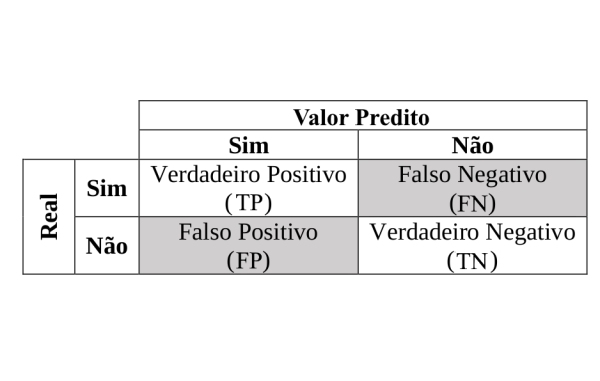

In [ ]:
# Lista utilizada para armazenar as métricas obtidas em cada classificador
evaluation_metrics = []

In [ ]:
# Imprime as métricas dos classificadores para facilitar a comparação
def print_evaluation_metrics(evaluation_metrics):
  if len(evaluation_metrics) == 0:
    print("Sem métricas registradas, favor rodar as células dos classificadores que se deseja comparar.")
    return

  for key in evaluation_metrics[0].keys():
    print(key,end='\t')

  print()
  for evaluation_metric in evaluation_metrics:
    for key, value in evaluation_metric.items():
      if type(value) == str:
        print(value,end='\t')
      else:
        print("{:.3f}".format(value),end='\t')
    print()

  print("\nLegenda:")
  print("NB1 = Naive Bayes utilizando a matriz TF-IDF calculada anteriormente")
  print("NB2 = Naive Bayes Calculando a matriz TF-IDF durante o pipeline de treinamento do modelo")
  print("LR = Logistic Regression")
  print("SVC = Linear Support Vector Classification")
  print("RFC = RandomForestClassifier")
  print("MLP = Multi-layer Perceptron classifier")
  print("ACC = Acurácia")
  print("F1 = F1-Score")
  print("PRE = Precisão")
  print("REC = Recall (Cobertura)")
  print("TT = Tempo de treinamento (segundos)")
  print("TC = Tempo de classificação (segundos)")
  print("TP = Verdadeiro Positivo")
  print("TN = Verdadeiro Negativo")
  print("FP = Falso Positivo")
  print("FN = Falso Negativo")

### Abordagens clássicas

Naive Bayes

Referências:
https://www.turing.com/kb/document-classification-using-naive-bayes

https://towardsdatascience.com/implementing-a-naive-bayes-classifier-for-text-categorization-in-five-steps-f9192cdd54c3

MultinomialNB é um classificador Naive Bayes
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html



Salvou o arquivo com o modelo treinado:NB1.pkl


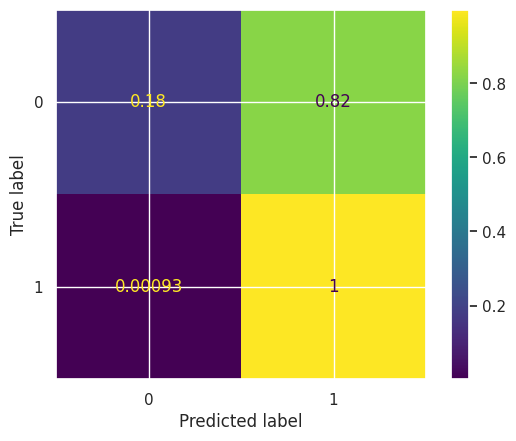

Acurácia: 0.589
F1-Score: 0.505
Precisão: 0.772
Recall (cobertura): 0.588
Tempo de treinamento (s): 0.039
Tempo de classificação (s): 0.005
Verdadeiro Positivo (TP): 0.999
Verdadeiro Negativo (TN): 0.178
Falso Positivo (FP): 0.822
Falso Negativo (FN): 0.001


In [ ]:
# Construção de uma modelo clássico usando Naive Bayes
# Utilizando a matriz TF-IDF calculada anteriormente
model = make_pipeline(MultinomialNB())
model_name="NB1"
evaluation_metric = fit_and_evaluate_model(model,model_name,X, df.label)
evaluation_metrics.append(evaluation_metric)

Salvou o arquivo com o modelo treinado:NB2.pkl


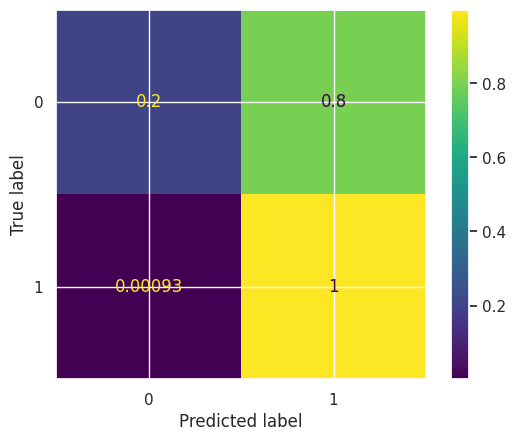

Acurácia: 0.602
F1-Score: 0.528
Precisão: 0.776
Recall (cobertura): 0.602
Tempo de treinamento (s): 2.144
Tempo de classificação (s): 1.102
Verdadeiro Positivo (TP): 0.999
Verdadeiro Negativo (TN): 0.205
Falso Positivo (FP): 0.795
Falso Negativo (FN): 0.001


In [ ]:
# Construção de uma modelo clássico usando Naive Bayes
# Calculando a matriz TF-IDF durante o pipeline do modelo
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_name="NB2"
evaluation_metric = fit_and_evaluate_model(model,model_name, df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

Regressão logística

Referências: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
*italicized text*

Salvou o arquivo com o modelo treinado:LR.pkl


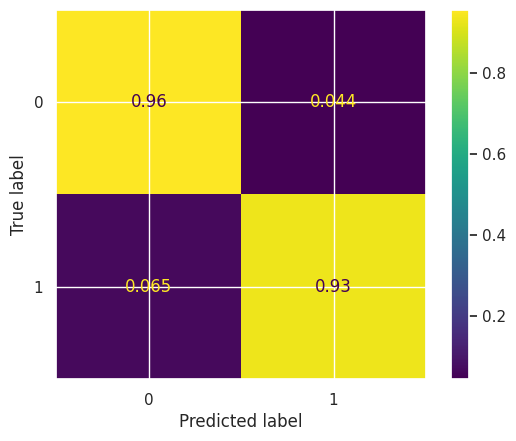

Acurácia: 0.945
F1-Score: 0.945
Precisão: 0.946
Recall (cobertura): 0.945
Tempo de treinamento (s): 2.959
Tempo de classificação (s): 1.220
Verdadeiro Positivo (TP): 0.935
Verdadeiro Negativo (TN): 0.956
Falso Positivo (FP): 0.044
Falso Negativo (FN): 0.065


In [ ]:
# Construção de uma modelo clássico usando Regressão logística
model = make_pipeline(TfidfVectorizer(), LogisticRegression())
model_name="LR"
evaluation_metric = fit_and_evaluate_model(model,model_name,df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

Linear Support Vector Classification

Referências:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


Salvou o arquivo com o modelo treinado:SVC.pkl


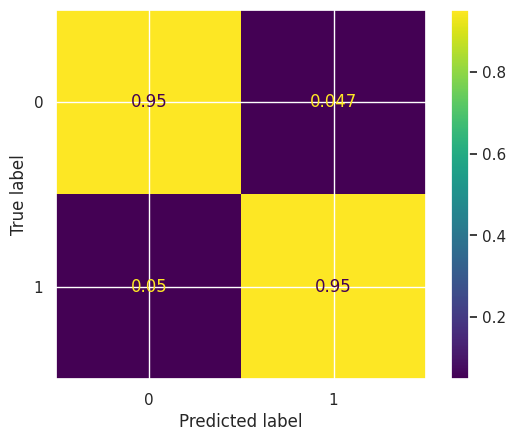

Acurácia: 0.952
F1-Score: 0.952
Precisão: 0.952
Recall (cobertura): 0.952
Tempo de treinamento (s): 2.387
Tempo de classificação (s): 0.497
Verdadeiro Positivo (TP): 0.950
Verdadeiro Negativo (TN): 0.953
Falso Positivo (FP): 0.047
Falso Negativo (FN): 0.050


In [ ]:
# Construção de uma modelo clássico usando Linear Support Vector Classification
model = make_pipeline(TfidfVectorizer(), LinearSVC())
model_name = "SVC"
evaluation_metric = fit_and_evaluate_model(model,model_name,df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

A random forest classifier.

Referências: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html



Salvou o arquivo com o modelo treinado:RFC.pkl


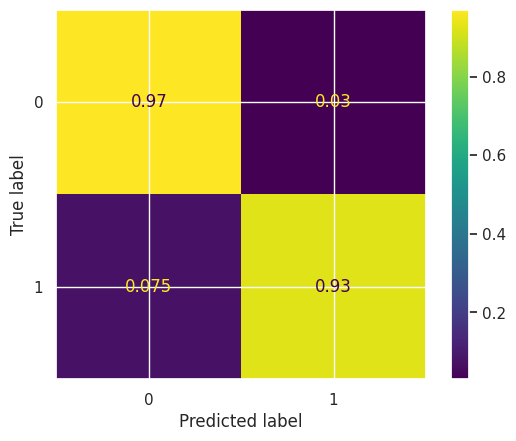

Acurácia: 0.948
F1-Score: 0.948
Precisão: 0.949
Recall (cobertura): 0.948
Tempo de treinamento (s): 4.077
Tempo de classificação (s): 0.544
Verdadeiro Positivo (TP): 0.925
Verdadeiro Negativo (TN): 0.970
Falso Positivo (FP): 0.030
Falso Negativo (FN): 0.075


In [ ]:
# Construção de uma modelo clássico usando RandomForestClassifier
model = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
model_name = "RFC"
evaluation_metric = fit_and_evaluate_model(model,model_name, df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

In [ ]:
print_evaluation_metrics(evaluation_metrics)

Model	ACC	F1	PRE	REC	TT(s)	TC(s)	TP	TN	FP	FN	
NB1	0.589	0.505	0.772	0.588	0.039	0.005	0.999	0.178	0.822	0.001	
NB2	0.602	0.528	0.776	0.602	2.144	1.102	0.999	0.205	0.795	0.001	
LR	0.945	0.945	0.946	0.945	2.959	1.220	0.935	0.956	0.044	0.065	
SVC	0.952	0.952	0.952	0.952	2.387	0.497	0.950	0.953	0.047	0.050	
RFC	0.948	0.948	0.949	0.948	4.077	0.544	0.925	0.970	0.030	0.075	
MLP	0.944	0.944	0.945	0.944	214.837	0.443	0.962	0.927	0.073	0.038	

Legenda:
NB1 = Naive Bayes utilizando a matriz TF-IDF calculada anteriormente
NB2 = Naive Bayes Calculando a matriz TF-IDF durante o pipeline de treinamento do modelo
LR = Logistic Regression
SVC = Linear Support Vector Classification
RFC = RandomForestClassifier
MLP = Multi-layer Perceptron classifier
ACC = Acurácia
F1 = F1-Score
PRE = Precisão
REC = Recall (Cobertura)
TT = Tempo de treinamento (segundos)
TC = Tempo de classificação (segundos)
TP = Verdadeiro Positivo
TN = Verdadeiro Negativo
FP = Falso Positivo
FN = Falso Negativo


# Abordagem usando rede neural
Multi-layer Perceptron classifier

Referências: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs
Salvou o arquivo com o modelo treinado:MLP.pkl


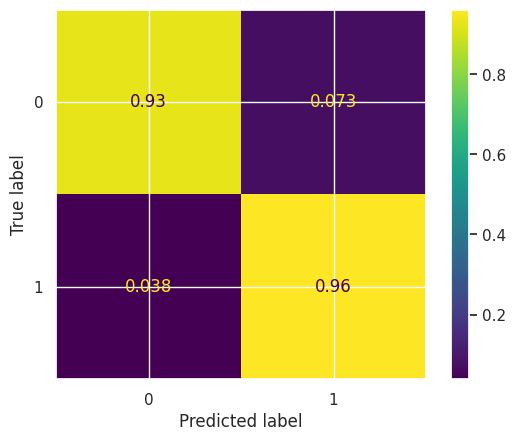

Acurácia: 0.944
F1-Score: 0.944
Precisão: 0.945
Recall (cobertura): 0.944
Tempo de treinamento (s): 214.837
Tempo de classificação (s): 0.443
Verdadeiro Positivo (TP): 0.962
Verdadeiro Negativo (TN): 0.927
Falso Positivo (FP): 0.073
Falso Negativo (FN): 0.038


In [ ]:
%time
# Atenção essa célula demora para rodar
# Construção de uma modelo clássico usando Multi-layer Perceptron classifier
model = make_pipeline(TfidfVectorizer(), MLPClassifier())
model_name = "MLP"
evaluation_metric = fit_and_evaluate_model(model,model_name,df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

In [ ]:
print_evaluation_metrics(evaluation_metrics)

Model	ACC	F1	PRE	REC	TT(s)	TC(s)	TP	TN	FP	FN	
NB1	0.589	0.505	0.772	0.588	0.039	0.005	0.999	0.178	0.822	0.001	
NB2	0.602	0.528	0.776	0.602	2.144	1.102	0.999	0.205	0.795	0.001	
LR	0.945	0.945	0.946	0.945	2.959	1.220	0.935	0.956	0.044	0.065	
SVC	0.952	0.952	0.952	0.952	2.387	0.497	0.950	0.953	0.047	0.050	
RFC	0.948	0.948	0.949	0.948	4.077	0.544	0.925	0.970	0.030	0.075	
MLP	0.944	0.944	0.945	0.944	214.837	0.443	0.962	0.927	0.073	0.038	

Legenda:
ACC = Acurácia
F1 = F1-Score
PRE = Precisão
REC = Recall (Cobertura)
TT = Tempo de treinamento (segundos)
TC = Tempo de classificação (segundos)
TP = Verdadeiro Positivo
TN = Verdadeiro Negativo
FP = Falso Positivo
FN = Falso Negativo


Modelo Batch (quando há uma série de notícias a serem avaliadas simultaneamente)

Model streaming (uma notícia por vez, em tempo real)

Salvar os parâmetros do modelo treinado considerando inferência em streaming no formato ‘pickle’

In [ ]:
# Observação: estou salvando o modelo treinado dentro da função "fit_and_evaluate_model"

def classifica_novo_texto(model_name, new_text):
  #Carrega o modelo treinado
  file_name = model_name+'.pkl'
  file_path="/content/"+file_name
  try:
    with open(file_path, 'rb') as f:
      model = pickle.load(f)
      #print(f"Carregou o modelo treinado: {file_path}")
      #Classifica o novo texto com o modelo
      classificacao = model.predict(new_text)
      print(classificacao)
  except Exception as error:
    print("Falha ao carregar o modelo treinado.")
    print(f"Exceção: {error} ")


In [ ]:
new_text = ["guta oriental entenda regiao siria sob intenso ataque chegou crise humanitaria regiao proxima damasco sitiada desde alvo intensos bombardeios regime sirio mortos ataques desde domingo passam nesta semana regiao arredores damasco siria chamou atencao noticiario internacional ser palco sangrentos bombardeios resultaram mortes civis apenas horas guta oriental antigo destino viagens final semana moradores capital siria atualmente ultimos redutos rebeldes lutam contra regime ditador bashar nesta regiao cerca quilometros quadrados mil pessoas vivem cercados forcas cerco guta oriental inicio dois anos explodir guerra siria balanco vitimas segunda maior ja registrado horas desde ano regiao alvo ataque quimico apesar ser isolada bombardeada ha anos desde dia fevereiro guta oriental alvo nova campanha aerea lancada regime assad aliado russia desde entao civis morreram bombardeios diarios segundo estimativa observatorio sirio direitos humanos osdh mortos ha criancas dia bombardeios retomados tropas chegaram regiao reforcar cerco preparar ofensiva terrestre ainda nao inicio parece forcas sirias russas tentam retomar territorio controle rebeldes qualquer custo neste sabado conselho seguranca onu aprovou unanimidade resolucao pede dias regiao objetivo facilitar chegada ajuda humanitaria resgate feridos aliada assad russia concordou resolucao apos exigir mudancas teor texto veja seguir principais pontos explicam acontecendo guta oriental guta nome informal usado referir suburbios damasco ficam entorno rio barada antes guerra guta regiao agricola produtora vegetais frutas incluindo damasco ja maior fornecedor arroz acucar frutas vegetais capital tambem considerado pulmao verde onde habitantes capital passavam final semana residentes guta oriental primeiros rebelar contra regime assad regiao tomada rebeldes ano agitacao tornou conflito armado repressao manifestacoes sangrenta guerra civil julho opositores partiram luta armada formaram exercito sirio livre esl lancaram partir guta batalha contra damasco partir dessa regiao rebeldes lancam projeteis contra bairros damasco atualmente tres grupos principais lutam guta oriental piores ataques guerra civil siria ocorreu contra regiao foguetes contendo gas sarin lancados contra area segundo comprovou tarde onu organizacao proibicao armas quimicas opaq ataque deixou mortos ultimas semanas governo assad voltou ser acusado lancar varios ataques quimicos guta oriental nega janeiro osdh relatou casos asfixia cidade duma moradores fontes medicas falando ataque gas cloro janeiro ataque semelhante aconteceu arredores duma acordo osdh falou sete casos asfixia fevereiro embaixadora estados unidos nacoes unidas nikki haley disse havia evidencias claras confirmar uso cloro ataques leste ghuta constantes bombardeios aereos fogo artilharia alem deixar muitas vitimas civis destruiram edificios residenciais mercados escolas hospitais cerco regiao provocou aumento precos escassez commodities consequentemente gerou falta alimentos fome desnutricao crise humanitaria comboios humanitarios onu raramente conseguem entrar regiao onu condenou privacao deliberada alimentos civis tatica guerra apos publicacao fotografias chocantes criancas esqueleticas leste guta fundo nacoes unidas infancia unicef denunciou pior crise desnutricao desde inicio guerra criancas menores cinco anos sofrendo desnutricao grave contra janeiro apesar proximidade regiao damasco forcas assad negligenciaram guta oriental durante primeiros anos guerra civil porque concentraram recuperar areas consideradas cruciais sobrevivencia governo homs aleppo regioes proximas fronteira libano assim grupos atuam regiao anos acumular grande reserva armas municoes vinham rotas abastecimento deserto siria tambem tempo suficiente construir tuneis subterraneos secretos protegem ataques aereos militantes ainda conseguiram cultivar proprios alimentos"]
classifica_novo_texto("SVC", new_text)

['true']


In [ ]:
new_text = ["saiba sao senadores votaram favor aecio neves aecio livre leve solto podera retomar mandato alem escapar recolhimento noturno determinado primeira turma stf verdade tudo nao passou grande acordo nacional stf senado tudo votos favoraveis senador contrarios"]
classifica_novo_texto("RFC", new_text)

['fake']


# BERT

Referências:
https://www.tensorflow.org/text/tutorials/classify_text_with_bert

https://arxiv.org/abs/1810.04805